Source: https://www.kaggle.com/datagov/usa-names/data
<br>Example Code from: https://www.kaggle.com/diamazov/unique-generation-names

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly as plo
import seaborn as sns
import numpy as np

# Preparing Models
from sklearn.model_selection import train_test_split

# Model - Linear Regression
from sklearn import linear_model

# Model K Nearest Neigbor
from sklearn.neighbors import KNeighborsClassifier

# Model - Decision Tree
from sklearn import tree

# Decision Tree Visualization
from IPython.display import Image
import pydotplus
import graphviz

# Ensemble - Random Forest
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

In [2]:
names = pd.read_csv('../data/usnames/names_per_year.csv')
del names['Unnamed: 0']
del names['year_total']
names.gender = names['gender'].apply(lambda val: 0 if val == 'F' else 1)

In [3]:
names.sample(5)

,year,gender,name
366712,1999,1,Enoc
59730,1964,0,Dusty
426405,1977,1,Kwame
275838,1989,0,Shanika
85863,2015,0,Luisa


In [4]:
names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613845 entries, 0 to 613844
Data columns (total 3 columns):
year      613845 non-null int64
gender    613845 non-null int64
name      613845 non-null object
dtypes: int64(2), object(1)
memory usage: 14.0+ MB


In [5]:
def vowelcheck(value):
    string=value.lower()
    vowels=0
    for i in string:
          if(i=='a' or i=='e' or i=='i' or i=='o' or i=='u'):
                vowels=vowels+1
    return vowels/len(string)

def consonantcluster(value):
    string=value.lower()
    end = len(string) - 1
    cc = 0
    for i, val in enumerate(string):
        if (i != end) and not (val=='a' or val=='e' or val=='i' or val=='o' or val=='u'):
                if string[i] == string[i+1]:
                    cc = cc + 1
                    
    return cc

def ycount(value):
    string=value.lower()
    y=0
    for i in string:
          if(i=='y'):
                y=y+1
    return y

def fvowel(value):
    string=value.lower()
    val = string[0]
    if (val=='a' or val=='e' or val=='i' or val=='o' or val=='u'):
        return 1
    else:
        return 0
    
def lcons(value):
    string=value.lower()
    val = string[-1]
    if (val=='a' or val=='e' or val=='i' or val=='o' or val=='u'):
        return 1
    else:
        return 0

In [6]:
names['len'] = names['name'].apply(lambda x: len(x))
names['vowelp'] = names['name'].apply(vowelcheck)
names['cc'] = names['name'].apply(consonantcluster)
names['yc'] = names['name'].apply(ycount)
names['fvowel'] = names['name'].apply(fvowel)
names['lcons'] = names['name'].apply(lcons)

In [7]:
names.head()

,year,gender,name,len,vowelp,cc,yc,fvowel,lcons
0,1921,0,Ah,2,0.5,0,0,1,0
1,1915,0,Ah,2,0.5,0,0,1,0
2,2000,0,Ai,2,1.0,0,0,1,1
3,2002,0,Ai,2,1.0,0,0,1,1
4,1995,0,Ai,2,1.0,0,0,1,1


In [8]:
# feature data for models
features = names.copy()
features.head()
features = features.sample(frac=1.0)

y = features['gender'].values.reshape(-1, 1)
X = features[['year', 'len', 'vowelp', 'cc', 'yc', 'fvowel','lcons']]

print(np.shape(y))
print(np.shape(X))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)  

(613845, 1)
(613845, 7)


## 1. Linear Regression (Ordinary Least Squares)

In [9]:
# Instantiate our model.
regr = linear_model.LinearRegression()

# Fit our model to our data.
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [10]:
# Display the attributes
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)

Coefficients: 
 [[-0.00068986 -0.01140742 -0.36365928 -0.12856177 -0.23982377  0.02134322
  -0.39493069]]
Intercept: 
 [2.29015836]


In [11]:
predY = regr.predict(X_test)

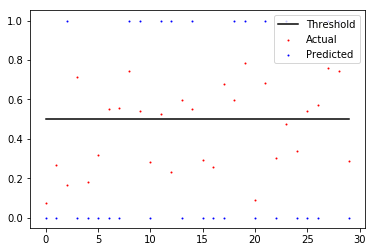

In [12]:
x = list(range(len(y_test[0:30])))
y =[0.5]*len(y_test[0:30])

plt.scatter(range(len(y_test[0:30])),predY[0:30],c='red',s=1)
plt.scatter(range(len(y_test[0:30])),y_test[0:30],c='blue',s=1)
plt.plot(x,y,c='black')
plt.legend(['Threshold','Actual','Predicted'],loc='upper right')
plt.show()

In [13]:
# score is low because of approximate values with lin regression - values need to be rounded
regr.score(X_test,y_test)

0.20752891116461336

In [14]:
# create vectorizer function for numpy
vfunc =  np.vectorize(lambda val: int(round(abs(val))))

# create final copy
final = X_test.copy()
final['gender'] = y_test
final['guessval'] = vfunc(regr.predict(X_test).ravel())

In [15]:
final.index.name = 'index'
names.index.name = 'index'
final = final.join(names['name'], how='left', on='index')

In [16]:
final.head()

,year,len,vowelp,cc,yc,fvowel,lcons,gender,guessval,name
index,,,,,,,,,,
10857,1994,4,0.500000,0,1,1,1,0,0,Ayla
129713,1996,6,0.500000,0,0,0,1,0,0,Breena
574573,1981,7,0.428571,1,0,0,1,1,0,Vanessa
197394,2009,6,0.333333,0,0,0,0,0,1,Shiloh
318095,1967,8,0.375000,1,0,0,1,0,0,Nichelle


In [17]:
print('{0:f}% of names were correctly identified by gender'.format(100*len(final.loc[final['gender'] == final['guessval']]) / len(final)))

71.877885% of names were correctly identified by gender


In [18]:
final.head()

,year,len,vowelp,cc,yc,fvowel,lcons,gender,guessval,name
index,,,,,,,,,,
10857,1994,4,0.500000,0,1,1,1,0,0,Ayla
129713,1996,6,0.500000,0,0,0,1,0,0,Breena
574573,1981,7,0.428571,1,0,0,1,1,0,Vanessa
197394,2009,6,0.333333,0,0,0,0,0,1,Shiloh
318095,1967,8,0.375000,1,0,0,1,0,0,Nichelle


## 2. K Nearest Neighbors

In [19]:
neighbors = KNeighborsClassifier(n_neighbors=5)
neighbors.fit(X_train, y_train.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [20]:
neighbors.score(X_test,y_test)

0.6828849767042802

## 3. Decision Tree

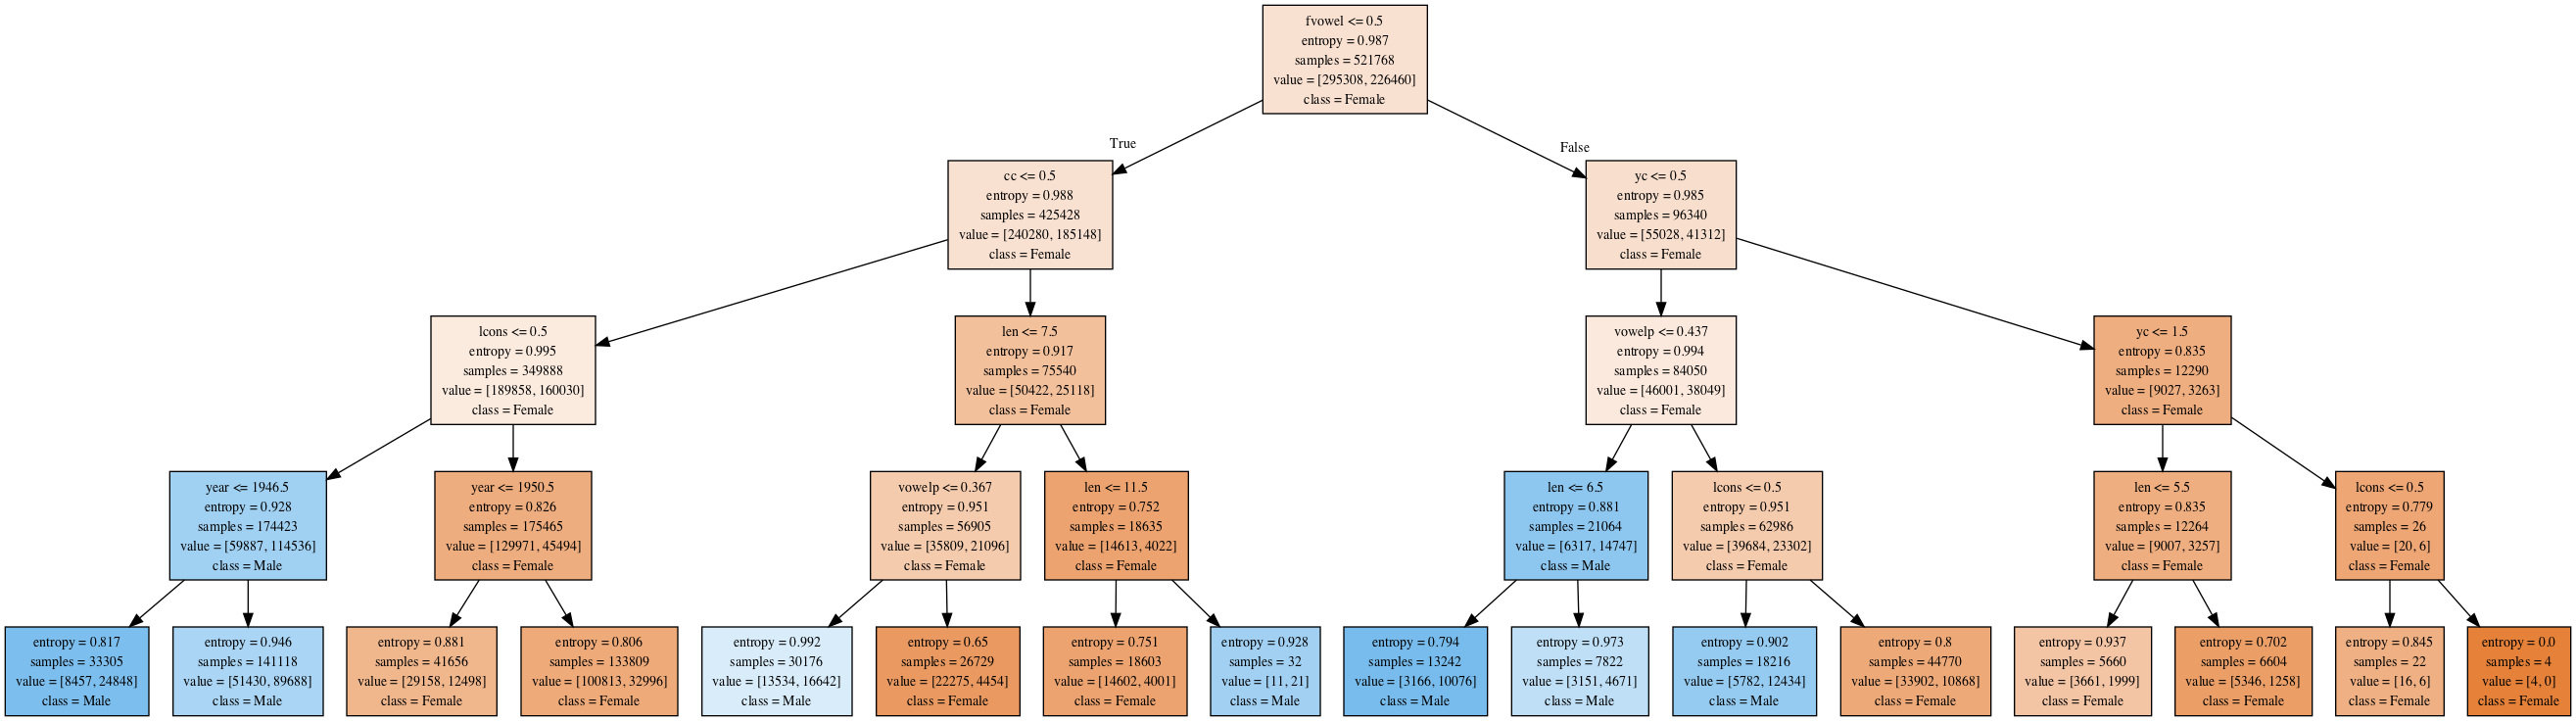

In [21]:
# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=4)

decision_tree.fit(X_train, y_train)

# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=['year', 'len', 'vowelp', 'cc', 'yc', 'fvowel','lcons'],
    class_names=['Female', 'Male'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [22]:
decision_tree.score(X_test,y_test)

0.7056593937682591

## 4. Random Forest

In [23]:
yForest = features['gender'].values.reshape(-1, 1)
XForest = features[['year', 'len', 'vowelp', 'cc', 'yc', 'fvowel','lcons']]


rfc = ensemble.RandomForestClassifier()

cross_val_score(rfc, XForest, yForest, cv=5)

/Users/ryan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Users/ryan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Users/ryan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Users/ryan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel(

array([0.72297793, 0.72055649, 0.72289422, 0.71970123, 0.71990258])